In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

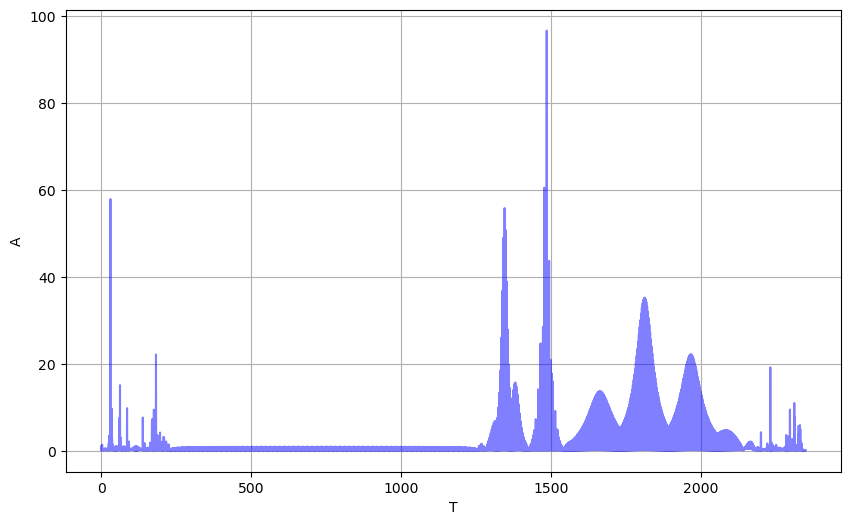

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:82: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:82: RuntimeWarning: invalid value encountered in log10
  plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)


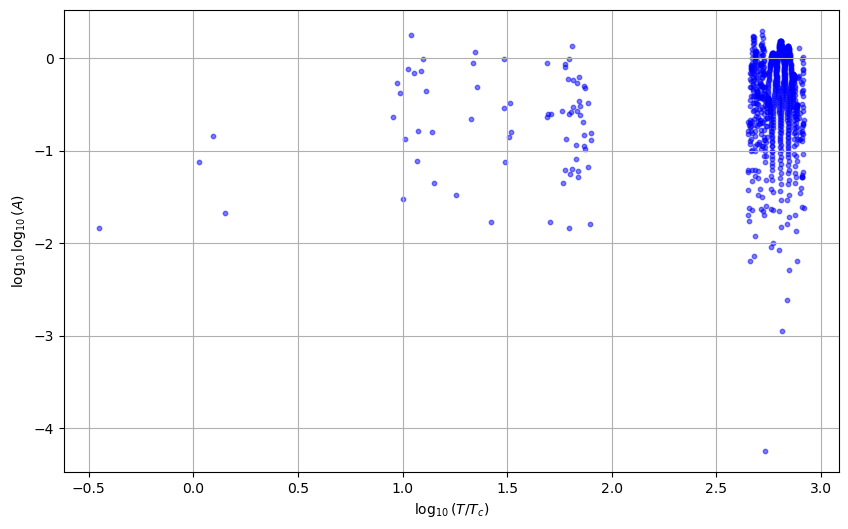

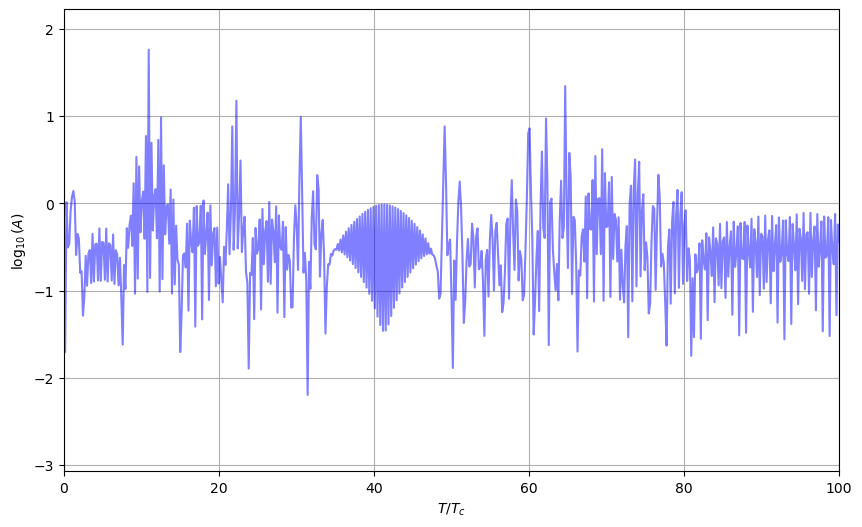

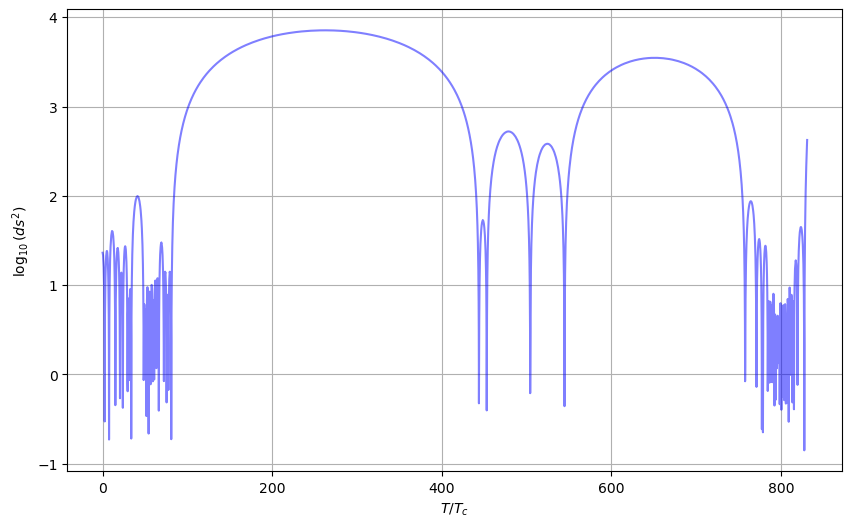

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:140: RuntimeWarning: invalid value encountered in scalar divide
  l_exponent = [np.log10(A[i]) / T_norm[i] for i in range(len(A))]
/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:146: RuntimeWarning: invalid value encountered in log10
  plt.scatter(T_norm, np.log10(l_timescale), color='b', alpha=0.5)


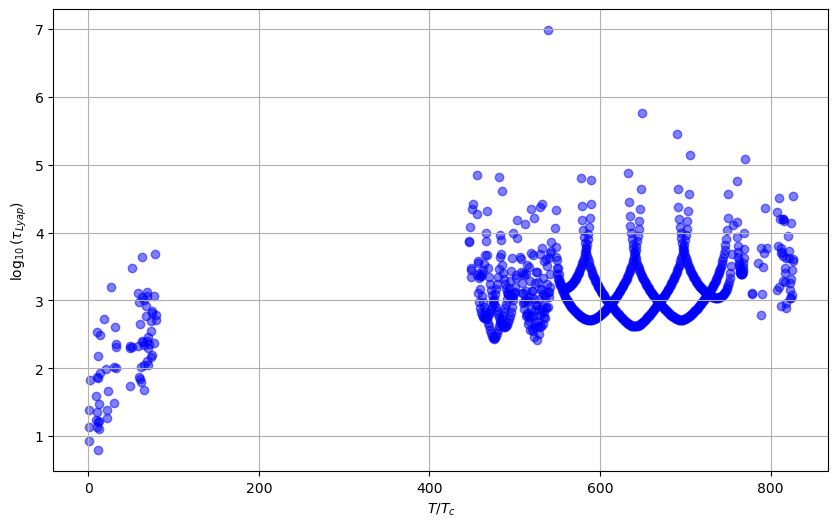

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:185: RuntimeWarning: invalid value encountered in log10
  sc = ax.scatter(x_positions, y_positions, np.log10(lyap_timescale), c=np.log10(lyap_timescale), cmap='viridis', alpha=0.7)


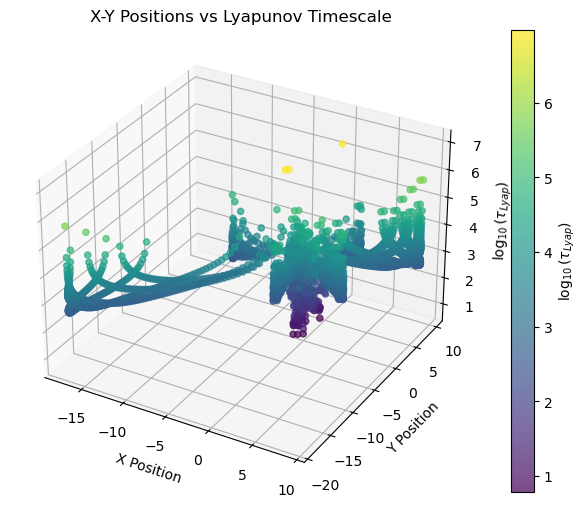

/var/folders/pz/5qchhm2j7nn9jlkwfg3_yckc0000gn/T/ipykernel_89307/678402015.py:199: RuntimeWarning: invalid value encountered in log10
  sc = ax.scatter(x_velocities, y_velocities, np.log10(lyap_timescale), c=np.log10(lyap_timescale), cmap='viridis', alpha=0.7)


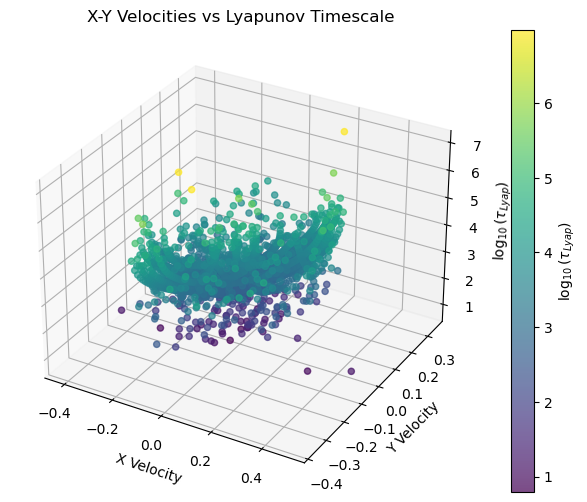

In [85]:
df = pd.read_csv('./Brutus data/plummer_triples_L0_00_i1775_e90_Lw392.csv')

forward_trajectory = df[df['Phase'] == 1]
backward_trajectory = df[df['Phase'] == -1]

total_timesteps = len(df['Timestep'].unique())
midpoint = total_timesteps // 2  # Midpoint corresponds to t=T=lifetime
timesteps = df['Timestep'].unique()

particles = df['Particle Number'].unique()

# Phase space distance between two states
def compute_delta(forward_state, backward_state):
    # Extract positions
    x_f, y_f, z_f = forward_state['X Position'].values, forward_state['Y Position'].values, forward_state['Z Position'].values
    x_b, y_b, z_b = backward_state['X Position'].values, backward_state['Y Position'].values, backward_state['Z Position'].values

    # Extract velocities
    vx_f, vy_f, vz_f = forward_state['X Velocity'].values, forward_state['Y Velocity'].values, forward_state['Z Velocity'].values
    vx_b, vy_b, vz_b = backward_state['X Velocity'].values, backward_state['Y Velocity'].values, backward_state['Z Velocity'].values

    # Compute the phase-space distance for this particle
    diff_vel = (vx_f - vx_b)**2 + (vy_f - vy_b)**2 + (vz_f - vz_b)**2
    diff_pos = (x_f - x_b)**2 + (y_f - y_b)**2 + (z_f - z_b)**2
    
    return np.sum(diff_vel + diff_pos)

# We want to compute delta btw backward and forward solutions at each integration step
# We need to consider the states symetrically around the midpoint
# backward state = total timesteps - 1 - current forward state
# forward state = current forward state (until midpoint)
delta_per_step = []

for i in range(len(timesteps) // 2):
    delta_sum = 0  
    for p in particles:
        forward_p = forward_trajectory[forward_trajectory['Particle Number'] == p]
        backward_p = backward_trajectory[backward_trajectory['Particle Number'] == p]
        
        forward_state = forward_p[forward_p['Timestep'] == timesteps[i]]
        backward_state = backward_p[backward_p['Timestep'] == timesteps[total_timesteps - 1 - i]]
        
        delta = compute_delta(forward_state, backward_state)
        delta_sum += delta
        
    delta_per_step.append(delta_sum)  # Append the delta summed over the bodies for this timestep

# We want to compute delta between initial and final states
delta_initial_final = 0

for p in particles:
    forward_p = forward_trajectory[forward_trajectory['Particle Number'] == p]
    backward_p = backward_trajectory[backward_trajectory['Particle Number'] == p]
    
    # Initial state from forward trajectory
    forward_initial = forward_p[forward_p['Timestep'] == 0]
    
    # Final state from backward trajectory
    max_backward_timestep = backward_p['Timestep'].max()
    backward_final = backward_p[backward_p['Timestep'] == max_backward_timestep]
    
    delta_initial_final += compute_delta(forward_initial, backward_final)

# Amplification factor for each integration step
A = [delta_initial_final/delta_per_step[i] for i in range(len(delta_per_step))]

# Amplification factor evolution over lifetime
plt.figure(figsize=(10, 6))
plt.plot(timesteps[:midpoint],A, color='b', alpha=0.5)
plt.xlabel('T')
plt.ylabel('A')
plt.grid(True)
plt.show()

# Crossing time 
T_c = 2 * np.sqrt(2)
# Normalize lifetime 
T_norm = [timesteps[i] / T_c for i in range(len(delta_per_step))]

# Scatter plot of A vs T/T_c   
plt.figure(figsize=(10, 6))
plt.scatter(np.log10(T_norm), np.log10(np.log10(A)), color='b', alpha=0.5, s=10)
plt.xlabel(r'$\log_{10}(T/T_c)$')
plt.ylabel(r'$\log_{10}\log_{10}(A)$')
plt.grid(True)
plt.show()
# Understand range values, is it correct? Different than the paper

# Amplification factor evolution over lifetime
plt.figure(figsize=(10, 6))
plt.plot(T_norm, np.log10(A), color='b', alpha=0.5)
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\log_{10}(A)$')
plt.xlim(0, 100)
#plt.ylim(0, 60)
plt.grid(True)
plt.show()

# Metric
# It is the sum of the squared distances between every pair of bodies
# Summed over the three particles

# We want to compute the metric considering squared distances between every pair of bodies (j > i)
# Use i and j as indices to distinguish the particles
# Trajectory to decide on backward or forward ??
def compute_metric(trajectory, timestep):
    ds = 0
    particles_positions = []
    
    for p in particles:
        particle_state = trajectory[(trajectory['Particle Number'] == p) & (trajectory['Timestep'] == timestep)]
        x, y, z = particle_state['X Position'].values, particle_state['Y Position'].values, particle_state['Z Position'].values
        particles_positions.append((x, y, z))
    
    for i in range(len(particles_positions)):
        for j in range(i+1, len(particles_positions)):
            xi, yi, zi = particles_positions[i]
            xj, yj, zj = particles_positions[j]
            ds += (xj - xi)**2 + (yj - yi)**2 + (zj - zi)**2
           
    return ds

# We want to compute the metric for each integration step
# Using the forward trajectory 
metric_per_step = []
for i in range(len(timesteps) // 2):
    metric = compute_metric(forward_trajectory, timesteps[i])
    metric_per_step.append(metric)

T_norm_metric = [timesteps[i] / T_c for i in range(len(metric_per_step))]
# Metric evolution over lifetime
plt.figure(figsize=(10, 6))
plt.plot(T_norm_metric, np.log10(metric_per_step), color='b', alpha=0.5)
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\log_{10}(ds^2)$')
plt.grid(True)
plt.show()

# Lyapunov exponent, for each integration step
l_exponent = [np.log10(A[i]) / T_norm[i] for i in range(len(A))]
# Lyapunov timescale (the inverse)
l_timescale = [1 / l_exponent[i] for i in range(len(l_exponent))]

# Lyapunov timescale vs T/T_c
plt.figure(figsize=(10, 6))
plt.scatter(T_norm, np.log10(l_timescale), color='b', alpha=0.5)
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\log_{10}(\tau_{Lyap})$')
plt.grid(True)
plt.show()

# 3D Phase space distribution of Lyapunov timescale
x_positions = []
y_positions = []
z_positions = []
x_velocities = []
y_velocities = []
z_velocities = []
lyap_timescale = []

for p in particles:
    particle_data = forward_trajectory[forward_trajectory['Particle Number'] == p]
    
    # Collect phase-space and Lyapunov data for each timestep
    for i in range(len(timesteps) // 2):
        x_pos = particle_data[particle_data['Timestep'] == timesteps[i]]['X Position'].values[0]
        y_pos = particle_data[particle_data['Timestep'] == timesteps[i]]['Y Position'].values[0]
        z_pos = particle_data[particle_data['Timestep'] == timesteps[i]]['Z Position'].values[0]
        x_vel = particle_data[particle_data['Timestep'] == timesteps[i]]['X Velocity'].values[0]
        y_vel = particle_data[particle_data['Timestep'] == timesteps[i]]['Y Velocity'].values[0]
        z_vel = particle_data[particle_data['Timestep'] == timesteps[i]]['Z Velocity'].values[0]
        x_positions.append(x_pos)
        y_positions.append(y_pos)
        z_positions.append(z_pos)
        x_velocities.append(x_vel)
        y_velocities.append(y_vel)
        z_velocities.append(z_vel)
        lyap_timescale.append(l_timescale[i])


# X-Y position
# Tried to add Z, dont like the result, what is best to do?
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_positions, y_positions, np.log10(lyap_timescale), c=np.log10(lyap_timescale), cmap='viridis', alpha=0.7)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel(r'$\log_{10}(\tau_{Lyap})$')
ax.set_title('X-Y Positions vs Lyapunov Timescale')

# To indicate scale of Lyapunov timescale
plt.colorbar(sc, label=r'$\log_{10}(\tau_{Lyap})$')
plt.show()

# X-Y velocity
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_velocities, y_velocities, np.log10(lyap_timescale), c=np.log10(lyap_timescale), cmap='viridis', alpha=0.7)

ax.set_xlabel('X Velocity')
ax.set_ylabel('Y Velocity')
ax.set_zlabel(r'$\log_{10}(\tau_{Lyap})$')
ax.set_title('X-Y Velocities vs Lyapunov Timescale')

# To indicate scale of Lyapunov timescale
plt.colorbar(sc, label=r'$\log_{10}(\tau_{Lyap})$')
plt.show()